# Recurrent neural networks and autoregressive modelling

In [ ]:
import jax
import jax.numpy as jnp
import jax.random as jrand
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import ast
import optax
import pickle
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import string
from collections import Counter
import flax.serialization
from google.colab import drive
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
import seaborn as sns

drive.mount('/content/drive')

Mounted at /content/drive


## Data Loading

The dataset is taken from [Kaggle](https://www.kaggle.com/datasets/paultimothymooney/recipenlg). It is called **RecipeNLG** and it is a cooking recipes dataset for semi-structured text generation. It contains 2,231,142 cooking recipes. It appears as a dataframe with 2,231,142 rowsn and 6 columns `["title", "ingredients", "directions", "link", "source", "NER"]`. I preprocessed it on Kaggle notebooks as the amount of memory required for some operations exceeded the Colab limits. First I parsed the recipes and formatted them adding some special characters like RECIPE_START, STEP, ... in order to make the text more structured. I then uploaded the resulting text on [Kaggle](https://www.kaggle.com/datasets/giochelavaipiatti/recipes-tokenized?select=recipes_formatted_improved.txt). Next, I tokenized the text since NN cannot process raw text. My choice was to go with **character level** tokenization, inspired by [this blogpost by Karapathy](https://karpathy.github.io/2015/05/21/rnn-effectiveness/). Morevoer, I defined special tokens explicitly and tokenized them without breaking them into chars. Next, since the vocabulary size was very big but many tokens rarely occured, I substituted all tokens that appeared less then a threshold with a special token. This significantly helped the model to converge faster.

In this cell I write all the code I used on Kaggle to handle the df, parse, process and tokenize.

```
# Load data
df = pd.read_csv("/kaggle/input/recipenlg/RecipeNLG_dataset.csv")

# Since this resulted in a df with 2231142 rows and 7 columns ["Unnamed: 0", "title","ingredients",	"directions", "link", "source", "NER"]
# I reduced its size
df_cut = df.iloc[len(df) // 2:]

# Parse string of list as list
df_cut['ingredients'] = df_cut['ingredients'].apply(ast.literal_eval)
df_cut['directions'] = df_cut['directions'].apply(ast.literal_eval)

# Function to format recipes
def format_recipe(title, ingredients, instructions):
    ingredients_text = "\n".join(f"- {ing}" for ing in ingredients)
    # Add <STEP> and </STEP> around each instruction
    steps_text = "\n".join(f"<STEP> {i+1}. {step} </STEP>" for i, step in enumerate(instructions))

    return (
        f"<RECIPE_START>\n"
        f"<TITLE_START> {title} <TITLE_END>\n"
        f"<INGREDIENTS_START>\n{ingredients_text}\n<INGREDIENTS_END>\n"
        f"<INSTRUCTIONS_START>\n{steps_text}\n<INSTRUCTIONS_END>\n"
        f"<RECIPE_END>"
    )

# Apply formatting to data
formatted_recipes = df_cut.apply(
    lambda row: format_recipe(row['title'], row['ingredients'], row['directions']), axis=1
)

with open("recipes_formatted_improved.txt", "w", encoding="utf-8") as f:
    f.write("\n\n".join(formatted_recipes))

text = open("/kaggle/input/recipe-improv/recipes_formatted_improved.txt", encoding="utf-8").read()

# Define explicit special tokens
special_tokens = ['<PAD>', '<UNK>', '<RECIPE_START>', '<RECIPE_END>',
                  '<TITLE_START>', '<TITLE_END>', '<INGREDIENTS_START>', '<INGREDIENTS_END>',
                  '<INSTRUCTIONS_START>', '<INSTRUCTIONS_END>', '<STEP>','</STEP>']

# Combine existing chars with special tokens, ensure uniqueness, and sort
all_chars = sorted(list(set(text) - set(special_tokens)))
final_chars = special_tokens + all_chars

# Create vocabulary
str_to_int = {ch:i for i, ch in enumerate(final_chars)}
int_to_str = {i:ch for ch, i in str_to_int.items()}

# Save vocabulary (uploaded on Kaggle)
with open("vocab_improv.pkl", "wb") as f:
    pickle.dump((str_to_int, int_to_str), f)

#### Encoding
def encode_text_with_special_tokens(text_to_encode, str_to_int_map, special_tokens_list):
    encoded_indices = []
    i = 0
    max_special_token_len = max(len(tok) for tok in special_tokens_list) if special_tokens_list else 0

    while i < len(text_to_encode):
        matched_special_token = None
        # Try to match the longest special token first
        for token in sorted(special_tokens_list, key=len, reverse=True):
            if text_to_encode.startswith(token, i):
                matched_special_token = token
                break

        if matched_special_token:
            encoded_indices.append(str_to_int_map[matched_special_token])
            i += len(matched_special_token)
        else:
            # Fallback to individual character
            char = text_to_encode[i]
            encoded_indices.append(str_to_int_map.get(char, str_to_int_map['<UNK>']))
            i += 1

    return jnp.array(encoded_indices)

# Save encoded text (uploaded on Kaggle)
with open("/kaggle/input/recipe-improv/recipes_formatted_improved.txt", "r", encoding="utf-8") as f_in, open("tokenized_improved.bin", "wb") as f_out:
    while True:
        chunk = f_in.read(10_000)
        if not chunk:
            break
        encoded = np.array(encode_text_with_special_tokens(chunk, str_to_int, special_tokens), dtype=np.uint16)
        f_out.write(encoded.tobytes())
```



#### Further Pre-processing

In [ ]:
token_path = "/content/drive/MyDrive/Colab Notebooks/NNDS_fh/tokenized_improved.bin"
vocab_path = "/content/drive/MyDrive/Colab Notebooks/NNDS_fh/vocab_improv.pkl"

encoded = np.fromfile(token_path, dtype=np.uint16)

with open(vocab_path, "rb") as f:
    str_to_int, int_to_str = pickle.load(f)

In [ ]:
print("Encoded sequence length:", len(encoded))
print("First 100 tokens: \n",encoded[:100])

Encoded sequence length: 1184350393
First 100 tokens: 
 [  2  16   4  22  57  94  95  89  97  91 100  22  55 100  90  22  73  87
 107 105  87  93  91  22  64  87  99  88  87  98  87 111  87  22   5  16
   6  16  35  22  39  37  40  22  97  93  22  89  94  95  89  97  91 100
  22 106  94  95  93  94  22  92  95  98  98  91 106  34  22  90  95  89
  91  90  16  35  22 106 101 100 111  22  89  94  87  89  94  91 104  91
  29 105  22  89 104  91 101  98  91  22]


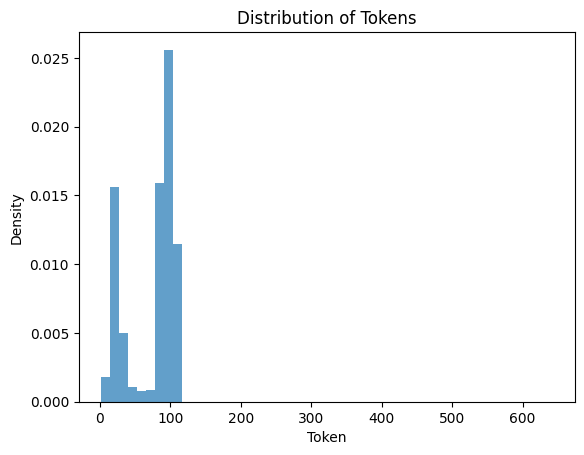

In [ ]:
# Plot distribution of tokens

plt.hist(encoded, bins=50, density=True, alpha=0.7)
plt.title("Distribution of Tokens")
plt.xlabel("Token")
plt.ylabel("Density")
plt.show()

In [ ]:
print("Vocabulary:", str_to_int)
print("Inverse vocabulary:", int_to_str)
print("Vocabulary size:", len(str_to_int))

Vocabulary: {'<PAD>': 0, '<UNK>': 1, '<RECIPE_START>': 2, '<RECIPE_END>': 3, '<TITLE_START>': 4, '<TITLE_END>': 5, '<INGREDIENTS_START>': 6, '<INGREDIENTS_END>': 7, '<INSTRUCTIONS_START>': 8, '<INSTRUCTIONS_END>': 9, '<STEP>': 10, '</STEP>': 11, '\x00': 12, '\x03': 13, '\x08': 14, '\t': 15, '\n': 16, '\x0b': 17, '\x10': 18, '\x11': 19, '\x1b': 20, '\x1f': 21, ' ': 22, '!': 23, '"': 24, '#': 25, '$': 26, '%': 27, '&': 28, "'": 29, '(': 30, ')': 31, '*': 32, '+': 33, ',': 34, '-': 35, '.': 36, '/': 37, '0': 38, '1': 39, '2': 40, '3': 41, '4': 42, '5': 43, '6': 44, '7': 45, '8': 46, '9': 47, ':': 48, ';': 49, '<': 50, '=': 51, '>': 52, '?': 53, '@': 54, 'A': 55, 'B': 56, 'C': 57, 'D': 58, 'E': 59, 'F': 60, 'G': 61, 'H': 62, 'I': 63, 'J': 64, 'K': 65, 'L': 66, 'M': 67, 'N': 68, 'O': 69, 'P': 70, 'Q': 71, 'R': 72, 'S': 73, 'T': 74, 'U': 75, 'V': 76, 'W': 77, 'X': 78, 'Y': 79, 'Z': 80, '[': 81, '\\': 82, ']': 83, '^': 84, '_': 85, '`': 86, 'a': 87, 'b': 88, 'c': 89, 'd': 90, 'e': 91, 'f': 92

In [ ]:
# Function to go from token back to char
def decode(encoded, vocab):
    dec_c = [vocab[int(idx)] for idx in encoded]
    print("".join(dec_c))

In [ ]:
print("Decoded sequence:")
decode(encoded[:700], int_to_str)

Decoded sequence:
<RECIPE_START>
<TITLE_START> Chicken And Sausage Jambalaya <TITLE_END>
<INGREDIENTS_START>
- 1/2 kg chicken thigh fillet, diced
- tony chachere's creole seasoning
- 1/2 cup margarine
- 4 large onions, chopped
- 4 garlic cloves, minced
- 2 stalks celery, chopped
- 1 bell pepper, chopped
- 1/2 lb smoked pork sausage
- 3 cups uncooked rice
- 4 cups water or 4 cups chicken stock
<INGREDIENTS_END>
<INSTRUCTIONS_START>
<STEP> 1. Season diced chicken generously with creole seasoning. </STEP>
<STEP> 2. Add margarine to large saucepan and fry chicken. </STEP>
<STEP> 3. Add all vegetables and saute for 10 minutes. </STEP>
<STEP> 4. Add sausage and rice, cook for 10 minutes, mixing as you go. </STEP>
<STEP> 5. Add water, stir well and keep covered until rice is fully cooked. </STEP>
<INSTRUCTIONS_END>
<RECIPE_END>

<RECIPE_START>
<TITLE_START> Fruity Bulgur Wheat <TITLE_END>
<INGREDIENTS_START>
- 10 ounces bulgur wheat
- 


In [ ]:
def find_rare_tokens(tokens, threshold=100):
    counts = Counter(tokens)
    rare_tokens = [token for token, freq in counts.items() if freq < threshold]
    return rare_tokens

rare_tokens = find_rare_tokens(encoded)
print("Number of rare tokens:", len(rare_tokens))

#with open("/content/drive/MyDrive/Colab Notebooks/NNDS_fh/rare_tokens.txt", 'w', encoding='utf-8') as f:
#        for token in rare_tokens:
#            f.write(str(token) + '\n')

Number of rare tokens: 511


Since there are mostly rare tokens in the vocabulary I decided to replace them with the \<UNK\> token to reduce the size of the vocabulary and help the model learn faster

In [ ]:
with open("/content/drive/MyDrive/Colab Notebooks/NNDS_fh/rare_tokens.txt", 'r', encoding='utf-8') as f:
    rare_tokens = [int(line.strip()) for line in f]

print(rare_tokens)

[196, 174, 192, 173, 170, 401, 168, 180, 175, 189, 172, 149, 156, 182, 152, 21, 190, 154, 162, 147, 146, 155, 141, 215, 136, 134, 292, 300, 313, 293, 301, 308, 312, 187, 18, 306, 309, 310, 297, 169, 151, 17, 219, 197, 413, 135, 20, 14, 13, 194, 153, 291, 298, 19, 160, 223, 143, 158, 406, 159, 133, 253, 181, 398, 123, 124, 121, 259, 248, 256, 255, 269, 457, 566, 558, 557, 128, 637, 142, 126, 118, 512, 573, 576, 125, 311, 305, 317, 119, 185, 396, 601, 613, 621, 610, 629, 614, 607, 626, 600, 227, 415, 642, 150, 120, 599, 615, 630, 586, 583, 384, 385, 163, 167, 127, 199, 608, 604, 628, 129, 130, 602, 622, 612, 631, 132, 144, 474, 491, 511, 567, 568, 250, 274, 273, 266, 244, 264, 261, 272, 263, 407, 395, 469, 470, 209, 623, 603, 617, 489, 513, 565, 606, 625, 383, 220, 388, 212, 510, 546, 579, 544, 569, 509, 543, 200, 203, 216, 166, 165, 389, 639, 574, 570, 494, 598, 527, 636, 468, 482, 416, 204, 632, 381, 224, 577, 515, 222, 423, 428, 427, 597, 483, 548, 522, 460, 206, 436, 453, 455, 449, 4

In [ ]:
# Filter tokens
filtered_tokens = [token for token in int_to_str.keys() if token not in rare_tokens]

# Create mapping from old index to new index
old_to_new_index = {old_idx: new_idx for new_idx, old_idx in enumerate(sorted(filtered_tokens))}

# Build new_int_to_str and new_str_to_int dictionaries
new_int_to_str = {}
new_str_to_int = {}

for old_idx in filtered_tokens:
    token = int_to_str[old_idx]
    new_idx = old_to_new_index[old_idx]
    new_int_to_str[new_idx] = token
    new_str_to_int[token] = new_idx

print(new_int_to_str)
print(new_str_to_int)

{0: '<PAD>', 1: '<UNK>', 2: '<RECIPE_START>', 3: '<RECIPE_END>', 4: '<TITLE_START>', 5: '<TITLE_END>', 6: '<INGREDIENTS_START>', 7: '<INGREDIENTS_END>', 8: '<INSTRUCTIONS_START>', 9: '<INSTRUCTIONS_END>', 10: '<STEP>', 11: '</STEP>', 12: '\t', 13: '\n', 14: ' ', 15: '!', 16: '"', 17: '#', 18: '$', 19: '%', 20: '&', 21: "'", 22: '(', 23: ')', 24: '*', 25: '+', 26: ',', 27: '-', 28: '.', 29: '/', 30: '0', 31: '1', 32: '2', 33: '3', 34: '4', 35: '5', 36: '6', 37: '7', 38: '8', 39: '9', 40: ':', 41: ';', 42: '<', 43: '=', 44: '>', 45: '?', 46: '@', 47: 'A', 48: 'B', 49: 'C', 50: 'D', 51: 'E', 52: 'F', 53: 'G', 54: 'H', 55: 'I', 56: 'J', 57: 'K', 58: 'L', 59: 'M', 60: 'N', 61: 'O', 62: 'P', 63: 'Q', 64: 'R', 65: 'S', 66: 'T', 67: 'U', 68: 'V', 69: 'W', 70: 'X', 71: 'Y', 72: 'Z', 73: '[', 74: '\\', 75: ']', 76: '^', 77: '_', 78: '`', 79: 'a', 80: 'b', 81: 'c', 82: 'd', 83: 'e', 84: 'f', 85: 'g', 86: 'h', 87: 'i', 88: 'j', 89: 'k', 90: 'l', 91: 'm', 92: 'n', 93: 'o', 94: 'p', 95: 'q', 96: 'r'

In [ ]:
#with open("/content/drive/MyDrive/Colab Notebooks/NNDS_fh/new_vocab_improv.pkl", "wb") as f:
#    pickle.dump((new_str_to_int, new_int_to_str), f)

with open("/content/drive/MyDrive/Colab Notebooks/NNDS_fh/new_vocab_improv.pkl", "rb") as f:
    new_str_to_int, new_int_to_str = pickle.load(f)

In [ ]:
# Get size of new vocabulary
true_voc_len = len(new_str_to_int)
print("New Vocabulary length:", true_voc_len)

New Vocabulary length: 132


In [ ]:
# Compute recipe lenght stats
def recipe_len_stats(encoded):
    lens = []
    counter = 0

    for token in encoded:
        counter += 1
        if token == 2:
            lens.append(counter - 1)
            counter = 0

    lengths_np = np.array(lens[1:])

    # Mean and median
    avg = np.mean(lengths_np)
    median = np.median(lengths_np)

    # Percentiles
    p75 = np.percentile(lengths_np, 75)
    p90 = np.percentile(lengths_np, 90)
    p95 = np.percentile(lengths_np, 95)
    max_len = np.max(lengths_np)
    min_len = np.min(lengths_np)

    print(f"Average recipe length: {avg:.2f}")
    print(f"Median recipe length: {median:.2f}")
    print(f"Min recipe length: {min_len}")
    print(f"Max recipe length: {max_len}")
    print(f"75th percentile length: {p75:.2f}")
    print(f"90th percentile length: {p90:.2f}")
    print(f"95th percentile length: {p95:.2f}")

In [ ]:
recipe_len_stats(encoded)

Average recipe length: 1062.06
Median recipe length: 916.00
Min recipe length: 42
Max recipe length: 17034
75th percentile length: 1315.00
90th percentile length: 1840.00
95th percentile length: 2262.00


Since the average recipe length is 1.000, I subset the encoded data in order to have around 200.000 recipes and work with more manageable data

In [ ]:
# Subset
subset_encoded = encoded[:200_000_000]
# Boolean mask where token is rare
subset_encoded[np.isin(subset_encoded, rare_tokens)] = 1
# Change old tokens with new
subset_encoded = np.vectorize(old_to_new_index.get)(subset_encoded)

In [ ]:
# Check if the new vocabulary is correct by decoding
print(subset_encoded[:100])
print(decode(subset_encoded[:150], new_int_to_str))
print("\n")
# Compare with old vocabulary
print(encoded[:100])
print(decode(encoded[:150], int_to_str))

[  2  13   4  14  49  86  87  81  89  83  92  14  47  92  82  14  65  79
  99  97  79  85  83  14  56  79  91  80  79  90  79 103  79  14   5  13
   6  13  27  14  31  29  32  14  89  85  14  81  86  87  81  89  83  92
  14  98  86  87  85  86  14  84  87  90  90  83  98  26  14  82  87  81
  83  82  13  27  14  98  93  92 103  14  81  86  79  81  86  83  96  83
  21  97  14  81  96  83  93  90  83  14]
<RECIPE_START>
<TITLE_START> Chicken And Sausage Jambalaya <TITLE_END>
<INGREDIENTS_START>
- 1/2 kg chicken thigh fillet, diced
- tony chachere's creole seasoning
- 1/2 cup margarine
- 4 large onions, ch
None


[  2  16   4  22  57  94  95  89  97  91 100  22  55 100  90  22  73  87
 107 105  87  93  91  22  64  87  99  88  87  98  87 111  87  22   5  16
   6  16  35  22  39  37  40  22  97  93  22  89  94  95  89  97  91 100
  22 106  94  95  93  94  22  92  95  98  98  91 106  34  22  90  95  89
  91  90  16  35  22 106 101 100 111  22  89  94  87  89  94  91 104  91
  29 105  22  89 

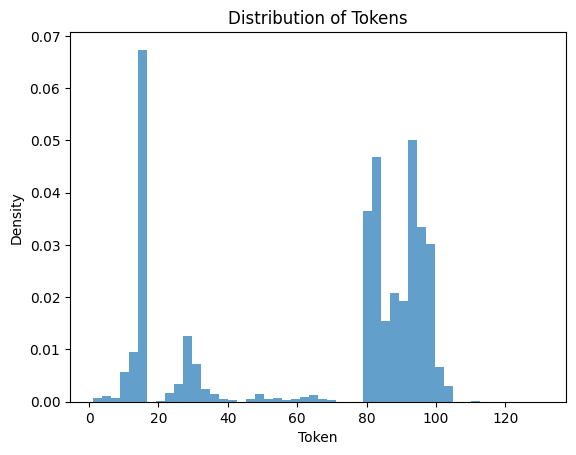

In [ ]:
# Plot distribution of subset with new tokens
plt.hist(subset_encoded, bins=50, density=True, alpha=0.7)
plt.title("Distribution of Tokens")
plt.xlabel("Token")
plt.ylabel("Density")
plt.show()

In [ ]:
# Check if recipe lenght stats remained similar for subset data
recipe_len_stats(subset_encoded)

Average recipe length: 1006.69
Median recipe length: 896.00
Min recipe length: 53
Max recipe length: 13353
75th percentile length: 1241.00
90th percentile length: 1682.00
95th percentile length: 2036.00


In [ ]:
# Function to get batches of data
def get_batch(encoded, seq_len, batch_size, key):
    N = len(encoded)
    # Select (batch_size,) random indices to start the sequences of the batch
    start_idx = jax.random.randint(key, (batch_size,), 0, N - seq_len)
    # Transform and broadcast to matrix (batch-size, seq_len)
    idx = start_idx[:, None] + jnp.arange(seq_len)[None, :]
    # Use jax fancy indexing to retreive all subsequences in one go
    x = encoded[idx]
    y = encoded[idx + 1]
    return x.astype(jnp.int32), y.astype(jnp.int32)

In [ ]:
batch_x, batch_y = get_batch(subset_encoded, 10, 4, jax.random.PRNGKey(42))
print("Input batch shape:", batch_x.shape)
print("Output batch shape:", batch_y.shape)

Input batch shape: (4, 10)
Output batch shape: (4, 10)


In [ ]:
decode(batch_x[0].tolist(), new_int_to_str)
print("")
decode(batch_y[0].tolist(), new_int_to_str)

parsley an

arsley and


## Training the recurrent model

I took inspiration for the task from the blog post [The Unreasonable Effectiveness of Recurrent Neural Networks](https://karpathy.github.io/2015/05/21/rnn-effectiveness/).

I decided to implement a character level LSTM language model since the recipes are not too long, but still require an expressive network to model long range dependencies. The model is traained to predict the next character in a sequence.

The model takes as input a seqeunce of tokens, embeds them into dense vectors and passes them through the LSTM network to produce a sequence of hidden states. These hiddens states are then projected onto the output space, that is the vocabulary space, to produce logits for predicting the next token at each time step.

#### Parameter Initialization
The embedding matrix is initiliazed randomly, while for the LSTM layer I use Glorot initialization to preserve activation variance during the forward pass and gradient variance during the backward pass, i.e. I sample weights from:
$$
U(- \sqrt{\frac{6}{input\_dim + output\_dim}}, + \sqrt{\frac{6}{input\_dim + output\_dim}})
$$

#### Model Design
- Embedding matrix
- LSTM kernel and bias
- Output projection layer

At each time step the previous hidden state and the input vector are concatenated and transformed into four gate vectors (i, f, c, o) that are used to update the internal cell state and compute the new hidden state.

Moreover, I also apply Inverted Dropout to outputs in order to try to improve generalization rather than memorizing exact sequences. Dropout is applied to the outputs of the recurrent layers, before the final logits projection.
As optimizer I use adam with standard parameters and I perform gradient clipping to prevent the vanishing/exploding gradient issue typical of recurrent models.

In [ ]:
## Utility functions
# Glorot uniform initialization
def glorot_init(key, in_dim, out_dim, dtype=jnp.float32):
    limit = jnp.sqrt(6.0 / (in_dim + out_dim))
    return jax.random.uniform(key, (in_dim, out_dim), dtype=dtype, minval=-limit, maxval=limit)

# Inverted Dropout
def apply_dropout(x, rate, key, training: bool):
    # Use dropout only if in training mode
    if not training or rate == 0.0:
        return x
    keep_prob = 1.0 - rate
    # Generate binary mask
    mask = jax.random.bernoulli(key, keep_prob, x.shape)
    return jnp.where(mask, x / keep_prob, 0.0)

## Parameter Initialization
def init_params(key, vocab_size, embedding_dim, hidden_dim):

    k_emb, k_ifco_kernel, k_ifco_bias, k_out_kernel, k_out_bias = jax.random.split(key, 5)

    params = {
        # Embedding layer
        'W_emb': jax.random.normal(k_emb, (vocab_size, embedding_dim)) * 0.02,

        ## LSTM Cell parameters
        # Kernel for concatenated [x_t, h_prev]
        'kernel_ifco': glorot_init(k_ifco_kernel, embedding_dim + hidden_dim, 4 * hidden_dim),
        # Bias for IFCO gates
        'b_ifco': jnp.zeros(4 * hidden_dim),

        # Output projection layer
        'W_out': glorot_init(k_out_kernel, hidden_dim, vocab_size),
        'b_out': jnp.zeros(vocab_size)
    }
    return params

## LSTM Cell
def lstm_cell(cell_params, carry, x_t):
    h_prev, c_prev = carry

    # Concatenate current input x_t and previous hidden state h_prev
    # x_t: (batch_size, embedding_dim), h_prev: (batch_size, hidden_dim)
    # -> concat_xh: (batch_size, embedding_dim + hidden_dim)
    concat_xh = jnp.concatenate([x_t, h_prev], axis=-1)

    # Linear transformation for all gates at once (suggesed by ChatGPT for better efficiency)
    # kernel_ifco: (embedding_dim + hidden_dim, 4 * hidden_dim), b_ifco: (4 * hidden_dim)
    # -> ifco_gates shape: (batch_size, 4 * hidden_dim)
    ifco_gates = jnp.dot(concat_xh, cell_params['kernel_ifco']) + cell_params['b_ifco']

    # Split into individual gates
    i, f, c, o = jnp.split(ifco_gates, 4, axis=-1)

    # Apply activation functions
    i = jax.nn.sigmoid(i)  # Input gate
    f = jax.nn.sigmoid(f)  # Forget gate
    c = jnp.tanh(c)  # Cell gate
    o = jax.nn.sigmoid(o)  # Output gate

    # Calculate next cell state and hidden state
    c_next = f * c_prev + i * c
    h_next = o * jnp.tanh(c_next)

    return (h_next, c_next), h_next

## Model Apply Function
def apply_model(params, tokens_input, training: bool = True, dropout_rate=0.1, key=None):

    if key is None:
        key = jax.random.PRNGKey(0)
    dropout_keys = jax.random.split(key, 2)

    batch_size, seq_len = tokens_input.shape
    embedding_dim = params['W_emb'].shape[-1]
    hidden_dim = params['W_out'].shape[0]

    # Embedding Lookup
    # W_emb: (vocab_size, embedding_dim) -> embeddings: (batch_size, seq_len, embedding_dim)
    embeddings = params['W_emb'][tokens_input]

    # Initial hidden state and cell state for LSTM
    h_initial = jnp.zeros((batch_size, hidden_dim), dtype=embeddings.dtype)
    c_initial = jnp.zeros((batch_size, hidden_dim), dtype=embeddings.dtype)
    initial_carry = (h_initial, c_initial)

    # Transpose embeddings for scan -> from batch-major to time-major: (seq_len, batch_size, embedding_dim)
    embeddings_time_major = jnp.transpose(embeddings, (1, 0, 2))

    # LSTM scan
    cell_params_for_scan = {'kernel_ifco': params['kernel_ifco'], 'b_ifco': params['b_ifco']}

    # Since jax.lax.scan expects a function of the form (carry, x_t) -> (new_carry, y_t),
    # we define a wrapper that captures 'cell_params_for_scan', which are static throughout the scan
    def scan_fn_wrapper(carry, x_t):
        return lstm_cell(cell_params_for_scan, carry, x_t)

    # all_hidden_states_time_major: (seq_len, batch_size, hidden_dim)
    _, all_hidden_states_time_major = jax.lax.scan(scan_fn_wrapper, initial_carry, embeddings_time_major)

    # Transpose hidden states back to batch-major -> all_hidden_states: (batch_size, seq_len, hidden_dim)
    all_hidden_states = jnp.transpose(all_hidden_states_time_major, (1, 0, 2))

    # Apply dropout
    all_hidden_states = apply_dropout(all_hidden_states, dropout_rate, dropout_keys[0], training)

    # Output Projection
    # W_out: (hidden_dim, vocab_size), b_out: (vocab_size)
    # output_logits: (batch_size, seq_len, vocab_size)
    # (B, S, H) @ (H, V) -> (B, S, V)
    output_logits = jnp.dot(all_hidden_states, params['W_out']) + params['b_out']

    return output_logits

## Loss Function
def calculate_loss_fn(logits, targets):
    loss_per_token = optax.softmax_cross_entropy_with_integer_labels(logits=logits, labels=targets)
    return jnp.mean(loss_per_token)

In [ ]:
# Model hyperparameters
vocab_size = len(new_str_to_int) # 132
embedding_dim = 64
hidden_dim = 512
seq_len = 1200  # avg sequence length is around 1000, but 75th percentile is around 1200
batch_size = 64

print(f"Vocab size: {vocab_size}")
print(f"Batch size: {batch_size}, Sequence length: {seq_len}")
print(f"Embedding dim: {embedding_dim}, LSTM hidden dim: {hidden_dim}")

## Model Setup
key_master = jax.random.PRNGKey(0)
key_init, key_batch_train = jax.random.split(key_master)

# Initialize model parameters
params = init_params(key_init, vocab_size, embedding_dim, hidden_dim)
print(f"Initialized parameter keys: {list(params.keys())}")
print(f"W_emb shape: {params['W_emb'].shape}")
print(f"kernel_ifco shape: {params['kernel_ifco'].shape}")
print(f"W_out shape: {params['W_out'].shape}")


## Optimizer
def init_adam_state(params):
    # initialize first and second moment trees and step counter
    m = jax.tree.map(jnp.zeros_like, params)
    v = jax.tree.map(jnp.zeros_like, params)
    return {'m': m, 'v': v, 't': 0}

def adam_update(params, grads, state, lr=1e-3, beta1=0.9, beta2=0.999, eps=1e-8, max_grad_norm=1.0):
    # Increment step
    t = state['t'] + 1

    # Compute global norm and clip (by ChatGPT)
    g_norm = jnp.sqrt(sum([jnp.vdot(g, g) for g in jax.tree.leaves(grads)]))
    clip_coef = jnp.minimum(1.0, max_grad_norm / (g_norm + 1e-6))
    grads = jax.tree.map(lambda g: g * clip_coef, grads)

    # Update biased first and second moments
    m = jax.tree.map(lambda m, g: beta1 * m + (1 - beta1) * g, state['m'], grads)
    v = jax.tree.map(lambda v, g: beta2 * v + (1 - beta2) * (g**2), state['v'], grads)

    # Bias corrected estimates
    m_hat = jax.tree.map(lambda m: m / (1 - beta1**t), m)
    v_hat = jax.tree.map(lambda v: v / (1 - beta2**t), v)

    # Parameter update
    updates = jax.tree.map(lambda m_h, v_h: lr * (m_h / (jnp.sqrt(v_h) + eps)), m_hat, v_hat)
    new_params = jax.tree.map(lambda p, u: p - u, params, updates)

    new_state = {'m': m, 'v': v, 't': t}
    return new_params, new_state

opt_state = init_adam_state(params)
learning_rate = 1e-3

## Define Training Step
@jax.jit
def train_step(params, opt_state, x_batch, y_batch, key):
    # Compute loss and grads
    def loss_fn(p):
        logits = apply_model(p, x_batch, training=True, dropout_rate=0.2, key=key)
        return calculate_loss_fn(logits, y_batch)

    loss, grads = jax.value_and_grad(loss_fn)(params)

    # Update parameters and optimizer state
    new_params, new_opt_state = adam_update(params, grads, opt_state, lr=learning_rate)

    return new_params, new_opt_state, loss

Vocab size: 132
Batch size: 64, Sequence length: 1200
Embedding dim: 64, LSTM hidden dim: 512
Initialized parameter keys: ['W_emb', 'kernel_ifco', 'b_ifco', 'W_out', 'b_out']
W_emb shape: (132, 64)
kernel_ifco shape: (576, 2048)
W_out shape: (512, 132)



Start training loop for 20 epochs, 500 steps/epoch
Epoch 1/20, Step 50/500, Loss: 3.2595
Epoch 1/20, Step 100/500, Loss: 2.6943
Epoch 1/20, Step 150/500, Loss: 2.3121
Epoch 1/20, Step 200/500, Loss: 2.0638
Epoch 1/20, Step 250/500, Loss: 1.8818
Epoch 1/20, Step 300/500, Loss: 1.7581
Epoch 1/20, Step 350/500, Loss: 1.6328
Epoch 1/20, Step 400/500, Loss: 1.5289
Epoch 1/20, Step 450/500, Loss: 1.4143
Epoch 1/20, Step 500/500, Loss: 1.3155
--- Epoch 1 Average Loss: 2.1084 ---

Sample generation:
<RECIPE_START>; Strisked and salt and malf and cook to the packl
Epoch 2/20, Step 50/500, Loss: 1.2592
Epoch 2/20, Step 100/500, Loss: 1.2016
Epoch 2/20, Step 150/500, Loss: 1.1886
Epoch 2/20, Step 200/500, Loss: 1.2169
Epoch 2/20, Step 250/500, Loss: 1.1273
Epoch 2/20, Step 300/500, Loss: 1.0932
Epoch 2/20, Step 350/500, Loss: 1.0498
Epoch 2/20, Step 400/500, Loss: 1.0623
Epoch 2/20, Step 450/500, Loss: 1.0307
Epoch 2/20, Step 500/500, Loss: 1.0539
--- Epoch 2 Average Loss: 1.1411 ---

Sample gen

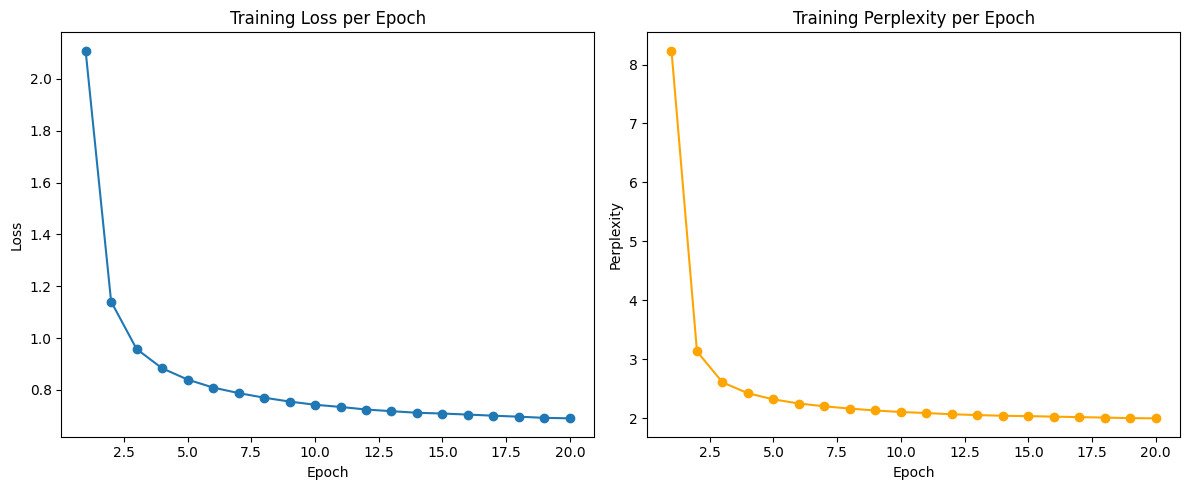

In [ ]:
# Naive function to generate tokens
def generate_tokens_naive(params, seed_text, length, temperature=1.0):
    input_seq = new_str_to_int[seed_text]
    generated = [input_seq]

    for _ in range(length):
        x = jnp.array(generated[-seq_len:])  # Use all tokens in generated
        x = x.reshape(1, -1)  # (1, seq_len)
        logits = apply_model(params, x, training=False)
        logits = logits[:, -1, :] / temperature
        probs = jax.nn.softmax(logits)
        key = jax.random.PRNGKey(np.random.randint(0, 10000))
        next_token = jax.random.categorical(key, logits)
        generated.append(int(next_token[0]))

    return ''.join([new_int_to_str[i] for i in generated])

## Training Loop
num_epochs = 20
steps_per_epoch = 500

loss_history = []
perplexity_history = []

print(f"\nStart training loop for {num_epochs} epochs, {steps_per_epoch} steps/epoch")
for epoch in range(num_epochs):
    key_epoch, key_batch_train = jax.random.split(key_batch_train)
    total_epoch_loss = 0.0

    for step in range(steps_per_epoch):
        key_step, key_batch_train = jax.random.split(key_batch_train)
        # Get a batch of data
        x_batch, y_batch = get_batch(subset_encoded, seq_len, batch_size, key_step)
        # Perform a training step
        params, opt_state, loss_value = train_step(params, opt_state, x_batch, y_batch, key_step)

        total_epoch_loss += loss_value

        if (step + 1) % 50 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}, Step {step+1}/{steps_per_epoch}, Loss: {loss_value:.4f}")

    avg_epoch_loss = total_epoch_loss / steps_per_epoch
    loss_history.append(avg_epoch_loss)
    perplexity_history.append(jnp.exp(avg_epoch_loss))

    print(f"--- Epoch {epoch+1} Average Loss: {avg_epoch_loss:.4f} ---")
    print("\nSample generation:")
    print(generate_tokens_naive(params, seed_text="<RECIPE_START>", length=50, temperature=0.6))

print("\nTraining finished.")

epochs = list(range(1, num_epochs + 1))

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, loss_history, marker='o')
plt.title("Training Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.subplot(1, 2, 2)
plt.plot(epochs, perplexity_history, marker='o', color='orange')
plt.title("Training Perplexity per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Perplexity")

plt.tight_layout()
plt.show()

In [ ]:
# Save the current state (parameters + optimizer state)
training_state = {
    "params": params,
    "opt_state": opt_state
}

#with open("/content/drive/MyDrive/Colab Notebooks/NNDS_fh/checkpoint1.msgpack", "wb") as f:
#    f.write(flax.serialization.to_bytes(training_state))

with open("/content/drive/MyDrive/Colab Notebooks/NNDS_fh/checkpoint1.msgpack", "rb") as f:
    bytes_data = f.read()

restored_state = flax.serialization.from_bytes(training_state, bytes_data)
params = restored_state["params"]

### Embeddings Analysis
Check learned embeddings to ensure model learns meaningful character relationships, in order to have an additional quality indicator of the model

Shape: (132, 64)
Max: 1.9322809 Min: -1.9731464


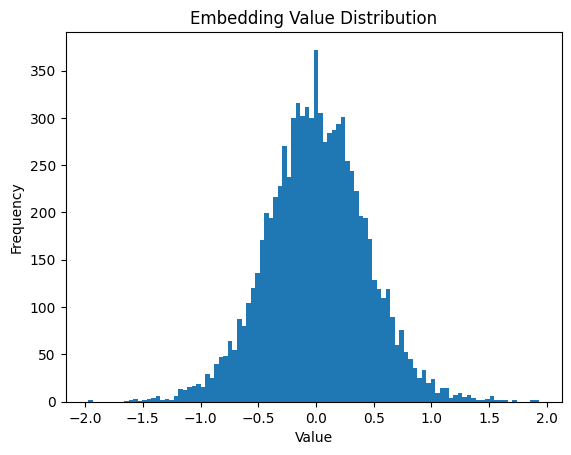

In [ ]:
W_emb = params["W_emb"]
print("Shape:", W_emb.shape)
print("Max:", W_emb.max(), "Min:", W_emb.min())

plt.hist(W_emb.flatten(), bins=100)
plt.title("Embedding Value Distribution")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()

In [ ]:
# Assign token to category (code written by ChatGPT)
def categorize_token(tok):
    if tok in string.ascii_letters:
        return 'letter'
    elif tok in string.digits:
        return 'digit'
    elif tok in string.punctuation or tok in ['\n', '\t', ' ']:
        return 'punctuation'
    elif tok.startswith('<') and tok.endswith('>'):
        return 'special'
    else:
        return 'other'

# Assign categories
categories = {}
category_colors = {'letter': 'blue', 'digit': 'green', 'punctuation': 'orange', 'special': 'red', 'other': 'gray'}

plot_indices = []
plot_colors = []
plot_labels = []

for idx in range(vocab_size):
    tok = new_int_to_str[idx]
    cat = categorize_token(tok)
    categories.setdefault(cat, []).append(idx)
    plot_indices.append(idx)
    plot_colors.append(category_colors[cat])
    plot_labels.append(cat)

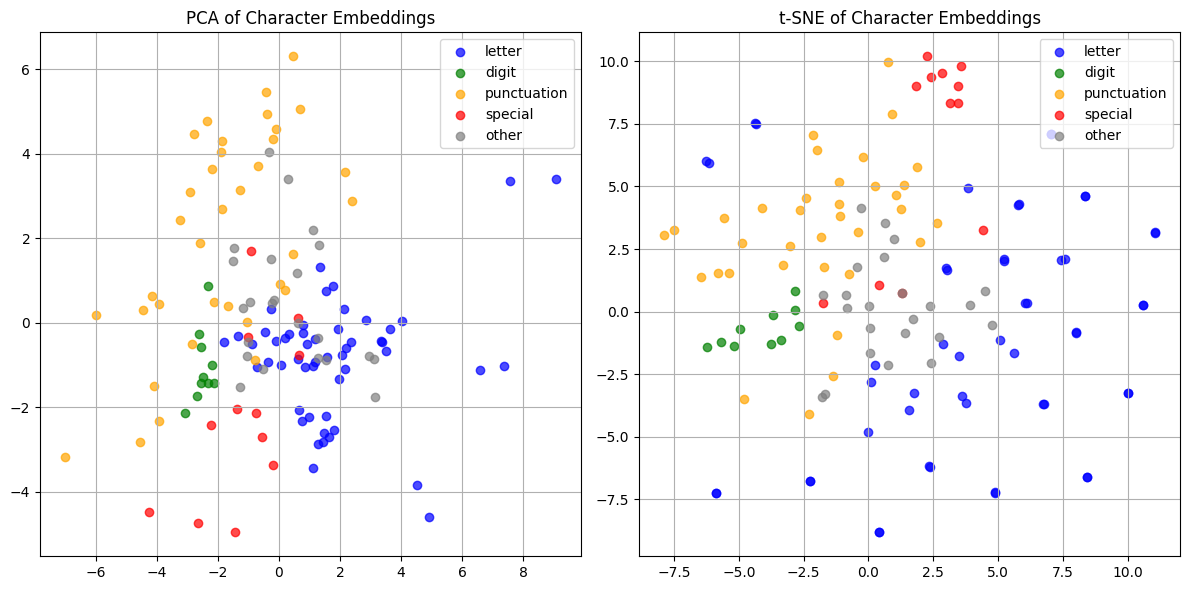

In [ ]:
W_np = np.array(W_emb)

# Scale
W_filtered = W_np[plot_indices]
W_scaled = StandardScaler().fit_transform(W_filtered)

# PCA
W_pca = PCA(n_components=2).fit_transform(W_scaled)
# t-SNE
W_tsne = TSNE(n_components=2).fit_transform(W_scaled)

# Plot (code written by ChatGPT)
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
for cat, color in category_colors.items():
    cat_indices = [i for i, label in enumerate(plot_labels) if label == cat]
    axs[0].scatter(W_pca[cat_indices, 0], W_pca[cat_indices, 1], label=cat, color=color, alpha=0.7)
axs[0].set_title("PCA of Character Embeddings")
axs[0].legend()
axs[0].grid(True)

for cat, color in category_colors.items():
    cat_indices = [i for i, label in enumerate(plot_labels) if label == cat]
    axs[1].scatter(W_tsne[cat_indices, 0], W_tsne[cat_indices, 1], label=cat, color=color, alpha=0.7)
axs[1].set_title("t-SNE of Character Embeddings")
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

The different classes of tokens appear well separated enough

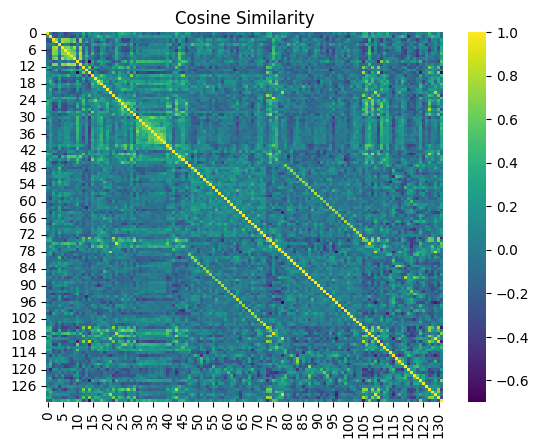

In [ ]:
# Compute and plot cosine similarity
cos_sim = cosine_similarity(W_emb)
sns.heatmap(cos_sim, cmap="viridis")
plt.title("Cosine Similarity")
plt.show()

Importantly, it is possible to notice upper case and lower case letter embeddings have very high cosine similarity. Also special characters embeddings exhibit significant similarity.

## Autoregressive generation

I implemented an autoregressive text generation function that generates sequences token by token using the LSTM model built previously. At each step the LSTM updates its hidden state and computes a distribution over the vocabulary, that uses to sample the next token. I introduce the possibility to control the randomness using the temperature parameter. With temperature = 0, this is equivalent to greedy sampling, while as the temperature increases it gets closers to random sampling. This function is more efficient then the `generate_tokens_naive` function because we avoid recomputing all previous steps at each iteration: each token is processed only once and the hidden and cell states are carried step by step.

In [ ]:
# Function to generate tokens in autoregressive fashion
def generate_tokens(params, start_token_ids, generate_length, temperature=1.0, key=jax.random.PRNGKey(0)):
    embedding_dim = params['W_emb'].shape[-1]
    hidden_dim = params['W_out'].shape[0]

    # Initialize hidden and cell state
    h_t = jnp.zeros((1, hidden_dim))
    c_t = jnp.zeros((1, hidden_dim))

    # Prime model with start tokens
    for token_id in start_token_ids[:-1]:
        x_t = params['W_emb'][token_id].reshape(1, -1)
        (h_t, c_t), _ = lstm_cell(
            {'kernel_ifco': params['kernel_ifco'], 'b_ifco': params['b_ifco']},
            (h_t, c_t),
            x_t
        )

    # Last token in the prompt is the input for generation
    last_token_id = start_token_ids[-1]
    x_t = params['W_emb'][last_token_id].reshape(1, -1)

    # Initialize generated list
    generated = [int(s_id) for s_id in start_token_ids]

    for i in range(generate_length):
        # Forward one step of the LSTM
        (h_t, c_t), h_out = lstm_cell(
            {'kernel_ifco': params['kernel_ifco'], 'b_ifco': params['b_ifco']},
            (h_t, c_t),
            x_t
        )

        # Project to logits
        logits = jnp.dot(h_out, params['W_out']) + params['b_out']  # (1, vocab_size)

        # Apply temperature and sample
        logits = logits / temperature
        probs = jax.nn.softmax(logits, axis=-1)

        key, subkey = jax.random.split(key)
        next_token_id = jax.random.categorical(subkey, logits).squeeze()

        # Append to generated sequence
        generated.append(int(next_token_id))

        # Prepare next input
        x_t = params['W_emb'][next_token_id].reshape(1, -1)

    return generated

In [ ]:
# Function to encode strings
def encode(str, vocab):
    return [vocab[char] for char in str]

encode('pizza', new_str_to_int)

[94, 87, 104, 104, 79]

In [ ]:
# Set function params
start_token_ids = [new_str_to_int['<RECIPE_START>'], new_str_to_int['\n'], new_str_to_int['<TITLE_START>'], new_str_to_int[' ']]
start_token_ids += encode('Pasta', new_str_to_int)
start_token_ids += [new_str_to_int[' '], new_str_to_int['<TITLE_END>']]

generate_length = 500
temperature = 0.8
key = jax.random.PRNGKey(42)

generated_ids = generate_tokens(params, start_token_ids, generate_length, temperature, key)
decode(generated_ids, new_int_to_str)

<RECIPE_START>
<TITLE_START> Pasta <TITLE_END>
<INGREDIENTS_START>
- 4 tablespoons chopped onions
- 2 tablespoons lakga cheese
- 2 heads fresh green pepper, chopped
- 1 large lemon, zested and juiced
- 1/2 cup brown sugar, finely chopped
- 1/2 cup sour cream
- 1 cup mayonnaise
- 1/4 cup chopped fresh dill (red pepper. </STEP>
<STEP> 3. Coarsely freshly ground black pepper
- 1 pinch ham, cubed
<INGREDIENTS_END>
<INSTRUCTIONS_START>
<STEP> 1. Mix the cream cheese with the sode only onto a large seraace bottle and warm the sauce over medium heat until the eggs are wilted, about 15 minutes. </STEP>
<STEP> 2. Add the butter


In [ ]:
%timeit generate_tokens(params, start_token_ids, generate_length, temperature, key)

3.68 s ± 596 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
# Changing temperature and increasing sequence length
start_token_ids = [new_str_to_int['<RECIPE_START>']]
generate_length = 1200
temperature = 0.9
key = jax.random.PRNGKey(42)

generated_ids = generate_tokens(params, start_token_ids, generate_length, temperature, key)
decode(generated_ids, new_int_to_str)

<RECIPE_START>
<TITLE_START> Stil Graed Chicken Rice <TITLE_END>
<INGREDIENTS_START>
- 1 lb ground beef
- 2 slices cabbage rounds
- 1/2 cup chopped onion
- 1 1/2 cups chicken stock
- 2 garlic cloves, minced
- 1/4 teaspoon pepper, ground
- 2 tablespoon beef broth, and or slivered
- 1 (8 ounce) package cheese (about 1 cup)
<INGREDIENTS_END>
<INSTRUCTIONS_START>
<STEP> 1. Season the pancakes with cocoa to your taste. </STEP>
<STEP> 2. Marinate the rest of the water demender on top of the cooker for 10 minutes in a don't full of the burner of). </STEP>
<STEP> 3. Stir in the orange juice, oil, thyme and 2 teaspoons lemon juice and onions. Let cook for 3-4 hours to cook or your cooking in the fridge, then add the food steaks and cook until potatoes are tender, about 5 minutes. </STEP>
<STEP> 4. Stir in the orange juice and season with salt and pepper. </STEP>
<STEP> 5. When the pasta is evaporated, combine the sugar and vegetable stock. </STEP>
<STEP> 6. Return to the boil, and cook for 15 m

I inlcude a top-k sampling strategy, that should improve coherence and diversity by restricting sampling to the most probable tokens.

In [ ]:
# Function to generate tokens in autoregressive fashion using top-k sampling strategy
def generate_tokens_topk(params, start_token_ids, generate_length, temperature=1.0, top_k=10, key=jax.random.PRNGKey(0)):
    embedding_dim = params['W_emb'].shape[-1]
    hidden_dim = params['W_out'].shape[0]

    h_t = jnp.zeros((1, hidden_dim))
    c_t = jnp.zeros((1, hidden_dim))

    # Prime model with start tokens
    for token_id in start_token_ids[:-1]:
        x_t = params['W_emb'][token_id].reshape(1, -1)
        (h_t, c_t), _ = lstm_cell(
            {'kernel_ifco': params['kernel_ifco'], 'b_ifco': params['b_ifco']},
            (h_t, c_t),
            x_t
        )

    # Last token in the prompt is the input for generation
    last_token_id = start_token_ids[-1]
    x_t = params['W_emb'][last_token_id].reshape(1, -1)

    # Initialize generated list
    generated = [int(s_id) for s_id in start_token_ids]

    for i in range(generate_length):
        # LSTM step
        (h_t, c_t), h_out = lstm_cell(
            {'kernel_ifco': params['kernel_ifco'], 'b_ifco': params['b_ifco']},
            (h_t, c_t),
            x_t
        )

        # Compute logits and apply temperature
        logits = jnp.dot(h_out, params['W_out']) + params['b_out']  # (1, vocab_size)
        logits = logits / temperature
        logits = logits.squeeze()  # (vocab_size,)

        # Top-k sampling
        topk_values, topk_indices = jax.lax.top_k(logits, top_k)  # (k,)
        topk_probs = jax.nn.softmax(topk_values)

        key, subkey = jax.random.split(key)
        sampled_index = jax.random.choice(subkey, top_k, p=topk_probs)
        next_token_id = topk_indices[sampled_index]

        # Append and prepare next input
        generated.append(int(next_token_id))
        x_t = params['W_emb'][next_token_id].reshape(1, -1)

    return generated

In [ ]:
# Set function params
start_token_ids = [new_str_to_int['<RECIPE_START>'], new_str_to_int['\n'], new_str_to_int['<TITLE_START>'], new_str_to_int[' ']]
start_token_ids += encode('Pizza Margherita', new_str_to_int)
start_token_ids += [new_str_to_int[' '], new_str_to_int['<TITLE_END>']]

generate_length = 500
temperature = 0.7
top_k = 10
key = jax.random.PRNGKey(42)

generated_ids =  generate_tokens_topk(params, start_token_ids, generate_length, temperature, top_k, key)
decode(generated_ids, new_int_to_str)

<RECIPE_START>
<TITLE_START> Pizza Margherita <TITLE_END>
<INGREDIENTS_START>
- 1/4 cup chopped fresh parsley
- 1/2 cup sugar
- 2 cups water
- 1 (14 ounce) can beer
- 1/2 cup sugar
<INGREDIENTS_END>
<INSTRUCTIONS_START>
<STEP> 1. Preheat oven to 325°F. </STEP>
<STEP> 2. Preheat oven to 350 degrees. </STEP>
<STEP> 3. In a large mixing bowl, whisk together egg yolks and vanilla until well mixed. </STEP>
<STEP> 4. Combine sugar, butter and vegetable oil in a deep baking dish. </STEP>
<STEP> 5. Bake at 350 for 1 hour. </STEP>
<STEP> 8. Roll out on lightly floured surface to a 11/2 cup serving dish. </STEP>
<STEP> 9. Bake custard for 15 minutes. </STEP>
<STEP> 10. Stir one side on a rack 


In [ ]:
%timeit generate_tokens_topk(params, start_token_ids, generate_length, temperature, top_k, key)

6.26 s ± 1.48 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
start_token_ids = [new_str_to_int['<RECIPE_START>']]
generate_length = 1200
temperature = 0.9
top_k = 10
key = jax.random.PRNGKey(42)

generated_ids =  generate_tokens_topk(params, start_token_ids, generate_length, temperature, top_k, key)
decode(generated_ids, new_int_to_str)

<RECIPE_START>
<TITLE_START> Chile Celery <TITLE_END>
<INGREDIENTS_START>
- 1 tablespoon olive oil
- 1 tablespoon soy sauce
- 1 teaspoon garlic powder
- 1 teaspoon salt
- 1 teaspoon ground cumin
- 1/2 teaspoon crushed red pepper flakes
- 2 cups mayonnaise
- 1/4 cup olive oil
- 1 pinch cayenne pepper
- 1/3 teaspoon salt
<INGREDIENTS_END>
<INSTRUCTIONS_START>
<STEP> 1. In heavy medium saucepan beat together the cream of mushroom, soy sauce, brown sugar, soy sauce, and potatoes with the remaining butter and simmer for 10 minutes. </STEP>
<STEP> 2. Meanwhile, heat the butter in a large saucepan over med-high heat. </STEP>
<STEP> 3. Pour the crumbs into a large mixing bowl. </STEP>
<STEP> 4. Add the olive oil, cloves and onion to soaked potatoes. </STEP>
<STEP> 5. Add the crab and stock and cook. </STEP>
<STEP> 8. Stir in the bananally, and the mushrooms/frozen ginger ale and then stir. </STEP>
<STEP> 9. Pour in the wet to boil, and cover the pan with the bacon and charting up on the side o

Compare with naive token generator function that recomputes the model on the entire sequence at each step

In [ ]:
%time print(generate_tokens_naive(params, seed_text="<RECIPE_START>", length=500, temperature=0.6))

<RECIPE_START>
<TITLE_START> Beans And Cheese <TITLE_END>
<INGREDIENTS_START>
- 1 lb steak sharp cheese
- 1/2 cup chopped onion
- 1/4 cup fresh ginger, grated
- 2 cloves garlic, minced
- 1 teaspoon salt
- 1/2 teaspoon pepper
- 1/2 - 1/4 teaspoon garlic powder
- 1/2 cup corn olive oil
- 1 tablespoon of flour
- 1/2 cup parmesan cheese, grated
<INGREDIENTS_END>
<INSTRUCTIONS_START>
<STEP> 1. Preheat oven to 350 degrees. </STEP>
<STEP> 2. Place bowl of bread mixture in a bowl with a spoon to add more sauce or blackberries and mix well. </STEP>
<STEP> 3. Pour batter into prepared baking dish. </STEP>
<STEP> 4. Bake at 350°F 
CPU times: user 3min 18s, sys: 6.25 s, total: 3min 25s
Wall time: 4min 4s


This sampling strategy is much slower, yet the output quality looks the same